In [1]:
import numpy as np  
import datetime
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras import Model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [6]:
TRAIN_PATH = '/Users/kashyapbastola/Desktop/TARP_PROJ/Pepsico RnD Potato Lab Dataset/Train'
TEST_PATH = '/Users/kashyapbastola/Desktop/TARP_PROJ/Pepsico RnD Potato Lab Dataset/Test'
BATCH_SIZE = 32
COLOR_MODE = 'rgb'
TARGET_SIZE = (255, 255)
GRAY_SCALL = (3,)
INPUT_SIZE = TARGET_SIZE + GRAY_SCALL
EPOCHS = 10
CLASSES = ['Defective','Non-Defective']

In [8]:
data_generator = ImageDataGenerator(samplewise_center=True, #making sure that each image has a mean of 0
                                    samplewise_std_normalization=True, #and standard deviation 1
                                    horizontal_flip=True, #Randomly flip inputs horizontally
                                    validation_split=0.3,
                                    )

In [9]:
train_data = data_generator.flow_from_directory(directory=TRAIN_PATH,target_size=TARGET_SIZE,batch_size=BATCH_SIZE,class_mode='categorical',color_mode=COLOR_MODE,subset='training',shuffle=True)         
    
validation_data = data_generator.flow_from_directory(directory=TRAIN_PATH,target_size=TARGET_SIZE,batch_size=BATCH_SIZE,class_mode='categorical',color_mode=COLOR_MODE,subset='validation',shuffle=True)             

test_data = data_generator.flow_from_directory(directory=TEST_PATH,target_size=TARGET_SIZE,batch_size=BATCH_SIZE,class_mode='categorical',color_mode=COLOR_MODE,shuffle=True)

Found 539 images belonging to 2 classes.
Found 230 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

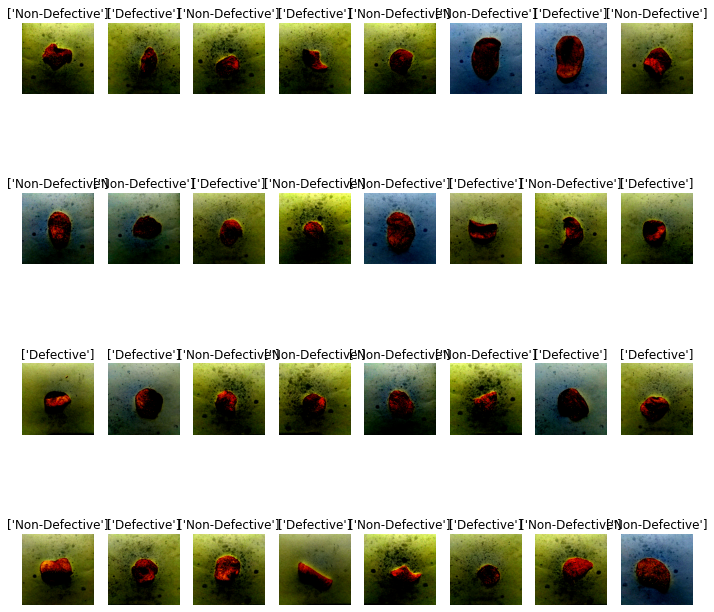

In [10]:
images, labels = train_data.next()
classes = np.asarray(CLASSES)

_, axs = plt.subplots(4, 8, figsize=(12,12))
axs = axs.flatten()
for img, label, ax in zip(images, labels, axs):
    ax.imshow(img)
    ax.axis('off')
    label = label.astype(int)
    ax.set_title(classes[label == 1])
plt.show()

In [11]:
def my_model():
  vgg19_model = VGG19(weights='imagenet',include_top=False,input_shape=INPUT_SIZE)
  vgg19_model.trainable = False
  flatten =Flatten()(vgg19_model.layers[-1].output)
  fc1 = Dense(units=4096, activation ='relu')(flatten)
  dropout = Dropout(0.2)(fc1)
  fc2 = Dense(units=1024,activation='relu')(dropout)
  output = Dense(2, activation='softmax')(fc2)
  model = Model(inputs = vgg19_model.input, outputs=output)
  model.summary()
  return model

In [12]:
model = my_model()

2022-08-02 22:20:56.515745: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


80134624/80134624 [==============================] - 1031s 13us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 255, 255, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 255, 255, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 127, 127, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 127, 127, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 127, 127, 128)     147584    
                                                          

In [13]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=False,show_layer_names=True, rankdir='T', expand_nested=False, dpi=96)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
loss = tf.keras.losses.CategoricalCrossentropy()

In [15]:
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [16]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='my_model.h5', 
                                                    monitor='accuracy', verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False, 
                                                    mode='auto', 
                                                    save_freq='epoch')
    
earlystoping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                                    min_delta=0, 
                                                    patience=5,  #Number of epochs with no improvement after which training will be stopped.
                                                    verbose=1, 
                                                    mode='auto')
    
log_dir = './logs/fit/' + datetime.datetime.now().strftime('%m.%d.%Y--%H-%M-%S')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                 histogram_freq=1, 
                                                 write_graph=True,
                                                 write_images=False, 
                                                 update_freq='epoch')

In [17]:
history = model.fit(x=train_data, 
                        epochs=EPOCHS, 
                        steps_per_epoch=len(train_data), 
                        verbose=1, 
                        validation_data=validation_data, 
                        validation_steps=1, 
                        callbacks=[checkpoint, earlystoping, tensorboard])
    
# -- Save model -- 
model.save('my_model.h5')

Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 10.5178 - accuracy: 0.5455 
Epoch 1: accuracy improved from -inf to 0.54545, saving model to my_model.h5
17/17 [==============================] - 347s 21s/step - loss: 10.5178 - accuracy: 0.5455 - val_loss: 0.2968 - val_accuracy: 0.9062
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.9369 
Epoch 2: accuracy improved from 0.54545 to 0.93692, saving model to my_model.h5
17/17 [==============================] - 340s 20s/step - loss: 0.1546 - accuracy: 0.9369 - val_loss: 0.1373 - val_accuracy: 0.9375
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9852 
Epoch 3: accuracy improved from 0.93692 to 0.98516, saving model to my_model.h5
17/17 [==============================] - 341s 20s/step - loss: 0.0334 - accuracy: 0.9852 - val_loss: 0.0727 - val_accuracy: 0.9688
Epoch 4/10
17/17 [==============================] - ETA: 0s - loss: 0.0074 - accura

In [18]:
def learning_curves(history):
    '''plot learning curves'''
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss - Cross Entropy')
    plt.xlabel('epoch')
    plt.ylim([0,1.6])
    plt.title('Training and Validation Loss')
    
    plt.show()

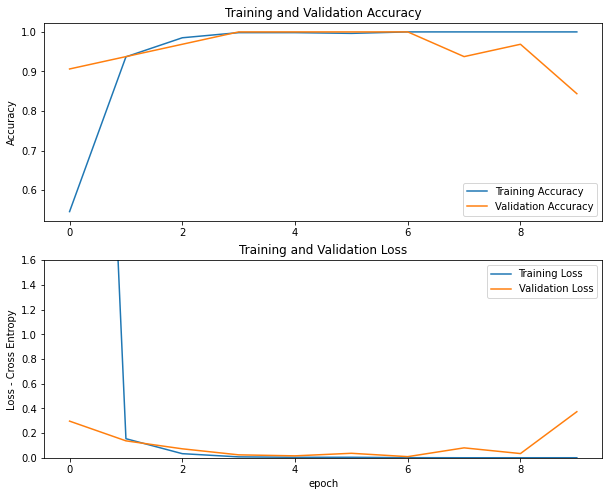

In [19]:
learning_curves(history)

In [21]:
# -- Evaluate the model on the test data -- 
loss, accuracy = model.evaluate(x=test_data)
print("test loss: ", loss, ", test acc: " , 100*accuracy, "%")

6/6 [==============================] - 89s 15s/step - loss: 0.4249 - accuracy: 0.8438
test loss:  0.42492803931236267 , test acc:  84.375 %


In [1]:
def defective_or_not(img_path):
    img = tf.keras.preprocessing.image.load_img('/Users/kashyapbastola/Desktop/TARP_PROJ/Pepsico RnD Potato Lab Dataset/Test/Defective/IMG_20210319_004702.jpg', target_size=(255,255,3))
    img = np.asarray(img)
    img = np.expand_dims(img, axis=0)
    model = tf.keras.models.load_model('my_model.h5')
    output = model.predict(img)
    print(classes[output[0]==1])